In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import fcluster
import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
traindf = pd.read_parquet('train.parquet', engine='pyarrow')

In [2]:
traindf.describe()

,horizon,ts_index,feature_a,feature_b,feature_c,feature_d,feature_e,feature_f,feature_g,feature_h,...,feature_ca,feature_cb,feature_cc,feature_cd,feature_ce,feature_cf,feature_cg,feature_ch,y_target,weight
count,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.278949e+06,...,5.337374e+06,5.337414e+06,5.334779e+06,4.937300e+06,5.061585e+06,5.101025e+06,5.297770e+06,5.337414e+06,5.337414e+06,5.337414e+06
mean,9.258638e+00,1.963320e+03,8.868155e+01,8.567391e+00,8.564846e+00,8.565059e+00,8.562926e+00,8.564357e+00,8.566521e+00,5.912386e-03,...,-2.811133e-01,-1.781311e-01,-4.609584e-01,-8.239401e-01,-2.288152e-02,1.472680e+00,1.062790e+00,2.323426e+00,-6.659048e-01,1.642788e+07
std,9.206252e+00,9.970220e+02,5.603141e+01,4.869982e+00,4.869406e+00,4.871465e+00,4.870096e+00,4.868880e+00,4.868368e+00,7.923729e-03,...,1.081776e+00,5.281133e-01,1.667862e+00,3.243581e+00,1.728989e-01,1.491990e+00,1.303983e+00,2.092968e+00,3.252764e+01,6.027074e+09
min,1.000000e+00,1.000000e+00,0.000000e+00,1.300042e-01,1.300016e-01,1.300009e-01,1.300028e-01,1.300075e-01,1.300021e-01,0.000000e+00,...,-9.311414e+01,-3.690332e+01,-1.346736e+02,-2.475901e+02,-7.684573e+00,6.128199e-03,1.606530e-02,0.000000e+00,-2.201882e+03,0.000000e+00
25%,1.000000e+00,1.148000e+03,4.000000e+01,4.350043e+00,4.350582e+00,4.346282e+00,4.346104e+00,4.347559e+00,4.348113e+00,3.744142e-04,...,-1.023971e-01,-1.325353e-01,-6.327619e-02,-1.022825e-01,-4.320754e-02,1.173612e-01,8.029312e-02,1.000000e+00,-1.290776e-01,1.553378e+01
50%,3.000000e+00,2.036000e+03,8.400000e+01,8.568381e+00,8.563840e+00,8.567354e+00,8.560350e+00,8.564697e+00,8.565921e+00,1.308027e-03,...,-1.306394e-02,-1.727560e-02,-1.316598e-02,-1.568063e-03,-1.886561e-03,1.197156e+00,1.594703e-01,2.000000e+00,-5.774818e-04,1.699384e+03
75%,1.000000e+01,2.814000e+03,1.330000e+02,1.278265e+01,1.278253e+01,1.278491e+01,1.278212e+01,1.278137e+01,1.278288e+01,1.047050e-02,...,-3.128947e-04,-2.017864e-04,-1.610013e-03,-5.537199e-04,1.675410e-02,2.524100e+00,1.991925e+00,3.000000e+00,5.106807e-02,1.641908e+05
max,2.500000e+01,3.601000e+03,2.130000e+02,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.109517e-01,...,0.000000e+00,-1.733807e-10,-9.195158e-11,4.884884e-05,2.642112e+00,1.363492e+01,1.056441e+01,1.000000e+01,2.314411e+03,1.391222e+13


## Drop entries in top and bottom 2.5% of y_target values

Target min: -25.252249881209888
Target max: 16.767371178084346


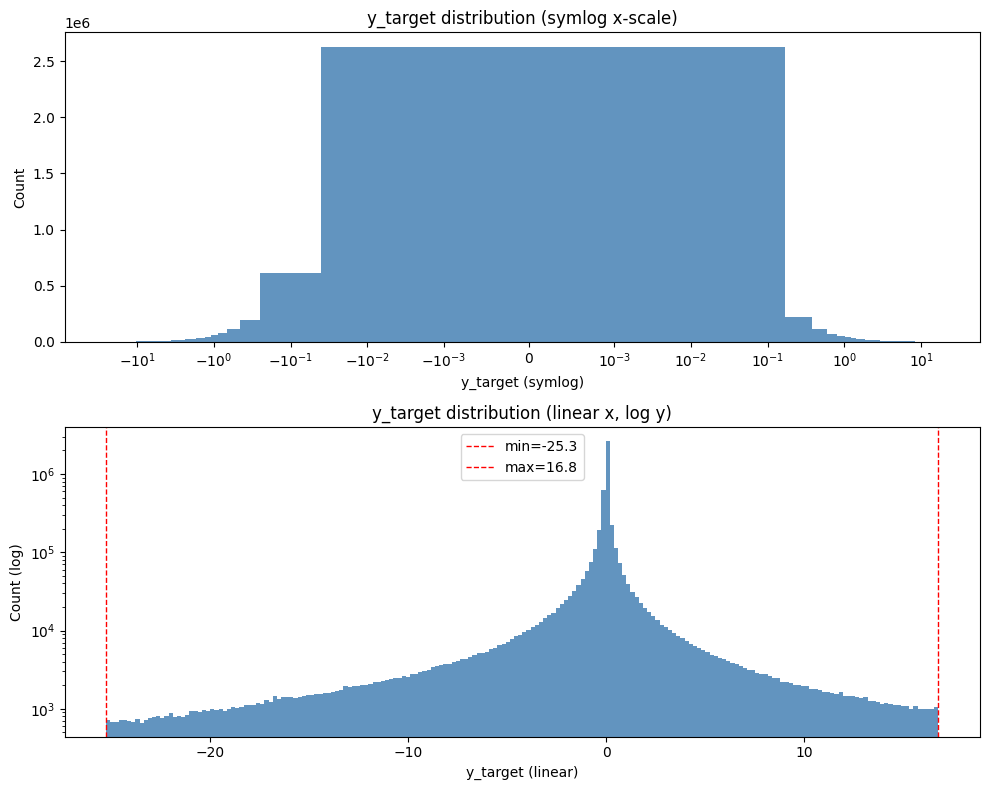

In [14]:
target_series = pd.Series(traindf['y_target'])

print(f'Target min: {min(target_series)}')
print(f'Target max: {max(target_series)}')


""" fig, ax = plt.subplots()
plt.figure(figsize=(200, 3))
ax.boxplot(target_series, vert=False, notch=True, showfliers=False, whis=[2.5,97.5])
plt.show() """

y = traindf["y_target"].dropna().values

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Panel 1: symlog x to show mass near 0
ax1.hist(y, bins=200, color="steelblue", alpha=0.85)
ax1.set_xscale("symlog", linthresh=1e-3)
ax1.set_title("y_target distribution (symlog x-scale)")
ax1.set_xlabel("y_target (symlog)")
ax1.set_ylabel("Count")

# Panel 2: linear x + log y to show extreme tails
ax2.hist(y, bins=200, color="steelblue", alpha=0.85)
ax2.set_yscale("log")
ax2.set_title("y_target distribution (linear x, log y)")
ax2.set_xlabel("y_target (linear)")
ax2.set_ylabel("Count (log)")

# annotate min/max to show tail extent
y_min, y_max = np.min(y), np.max(y)
ax2.axvline(y_min, color="red", linestyle="--", linewidth=1, label=f"min={y_min:.3g}")
ax2.axvline(y_max, color="red", linestyle="--", linewidth=1, label=f"max={y_max:.3g}")
ax2.legend()

plt.tight_layout()
plt.show()
# ...existing code...


In [4]:
print(f'Entries before: {len(traindf)}')

lower_bound = traindf['y_target'].quantile(0.025)
upper_bound = traindf['y_target'].quantile(0.975)
traindf = traindf[traindf['y_target'].between(lower_bound, upper_bound)]

print(f'Entries after: {len(traindf)}')

Entries before: 5337414
Entries after: 5070542


In [ ]:
print(traindf.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Index: 5070542 entries, 0 to 5337413
Data columns (total 94 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   code          object 
 2   sub_code      object 
 3   sub_category  object 
 4   horizon       int32  
 5   ts_index      int32  
 6   feature_a     int32  
 7   feature_b     float64
 8   feature_c     float64
 9   feature_d     float64
 10  feature_e     float64
 11  feature_f     float64
 12  feature_g     float64
 13  feature_h     float64
 14  feature_i     float64
 15  feature_j     float64
 16  feature_k     float64
 17  feature_l     float64
 18  feature_m     float64
 19  feature_n     float64
 20  feature_o     float64
 21  feature_p     float64
 22  feature_q     float64
 23  feature_r     float64
 24  feature_s     float64
 25  feature_t     float64
 26  feature_u     float64
 27  feature_v     float64
 28  feature_w     float64
 29  feature_x     float64
 30  feature_y     float64
 

## Fill empty values

In [5]:
highest_empty_values = traindf.isnull().sum().sort_values(ascending=False)[:10]

for feature in highest_empty_values.index:
    null_count = traindf[feature].isnull().sum()
    zero_count = (traindf[feature].values == 0).sum()
    df_len = len(traindf)

    print(f'Feature: {feature}')
    print(f'Null count: {null_count}')
    print(f'Null percent: {null_count*100/df_len}')
    print(f'Zero count: {zero_count}')
    print(f'Zero percent: {zero_count*100/df_len}')
    print(f'Combined count: {zero_count+zero_count}')
    print(f'Combined percent: {(zero_count+null_count)*100/df_len}')
    print()



Feature: feature_at
Null count: 661717
Null percent: 13.050222244485894
Zero count: 1855358
Zero percent: 36.590920655030565
Combined count: 3710716
Combined percent: 49.64114289951646

Feature: feature_by
Null count: 587841
Null percent: 11.593257683300918
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 11.593257683300918

Feature: feature_ay
Null count: 451766
Null percent: 8.909619523908884
Zero count: 1551358
Zero percent: 30.595506358097417
Combined count: 3102716
Combined percent: 39.505125882006304

Feature: feature_cd
Null count: 399825
Null percent: 7.885251714708211
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 7.885251714708211

Feature: feature_ce
Null count: 271022
Null percent: 5.345030176261236
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 5.345030176261236

Feature: feature_cf
Null count: 235191
Null percent: 4.6383798812829085
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 4.6383798812

count    4.408825e+06
mean     3.414494e+03
std      1.404742e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.082953e+01
75%      9.289349e+02
max      5.504714e+05
Name: feature_at, dtype: float64


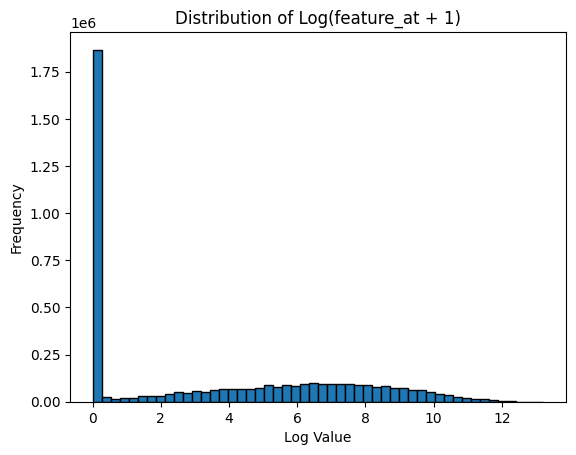

In [7]:
print(traindf['feature_at'].describe())

plt.hist(np.log1p(traindf['feature_at']), bins=50, edgecolor='black')
#plt.hist(traindf['feature_at'], bins=50, edgecolor='black')
plt.title('Distribution of Log(feature_at + 1)')
plt.xlabel('Log Value')
plt.ylabel('Frequency')
plt.show()

count    4.482701e+06
mean    -6.895940e-02
std      3.098222e-01
min     -3.022303e+01
25%     -2.717710e-02
50%     -3.871989e-03
75%     -4.071581e-04
max     -1.679419e-09
Name: feature_by, dtype: float64


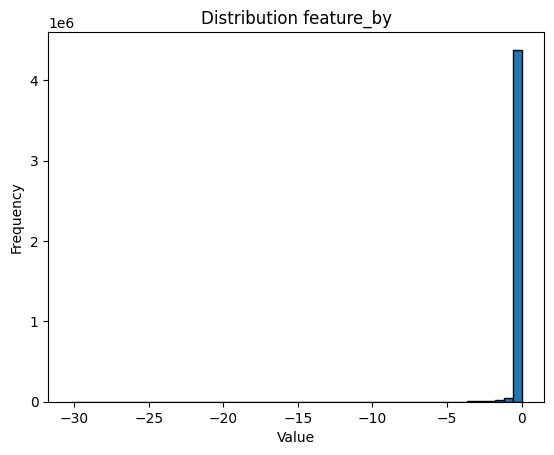

In [22]:
print(traindf['feature_by'].describe())

#plt.hist(np.log1p(traindf['feature_by']), bins=50, edgecolor='black')
plt.hist(traindf['feature_by'], bins=50, edgecolor='black')
plt.title('Distribution feature_by')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

count    4.618776e+06
mean     4.255352e+03
std      1.544016e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.007224e+02
75%      1.826091e+03
max      6.008947e+05
Name: feature_ay, dtype: float64


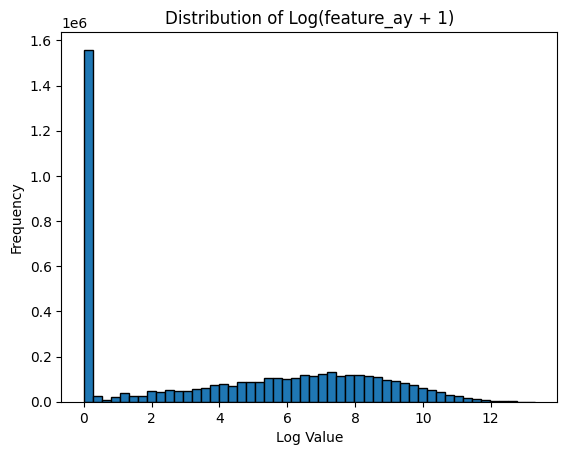

In [23]:
print(traindf['feature_ay'].describe())

plt.hist(np.log1p(traindf['feature_ay']), bins=50, edgecolor='black')
#plt.hist(traindf['feature_ay'], bins=50, edgecolor='black')
plt.title('Distribution of Log(feature_ay + 1)')
plt.xlabel('Log Value')
plt.ylabel('Frequency')
plt.show()

count    4.670717e+06
mean    -4.836989e-01
std      1.903950e+00
min     -2.475901e+02
25%     -8.435030e-02
50%     -1.306806e-03
75%     -5.314537e-04
max      4.884884e-05
Name: feature_cd, dtype: float64


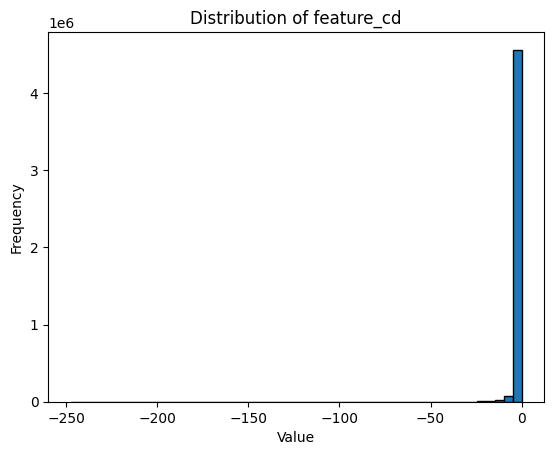

In [26]:
print(traindf['feature_cd'].describe())

#plt.hist(np.log1p(traindf['feature_cd']), bins=50, edgecolor='black')
plt.hist(traindf['feature_cd'], bins=50, edgecolor='black')
plt.title('Distribution of feature_cd')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Since the top missing values have such a high percent missing, I'll replace the missing values with mean/median, but also create another ohe column to represent that this was a missing value (probably for at, by, ay, and cd). The rest will just be replaced with mean/median

In [5]:
features_with_empty_values = traindf.isnull().sum().sort_values()

print(features_with_empty_values)

id                   0
code                 0
sub_code             0
sub_category         0
horizon              0
                 ...  
feature_ce      271022
feature_cd      399825
feature_ay      451766
feature_by      587841
feature_at      661717
Length: 94, dtype: int64


In [6]:
ohe_cols = ['feature_at', 'feature_by', 'feature_ay', 'feature_cd']
ignore_cols = ['id', 'code', 'sub_code', 'sub_category', 'horizon', 'y_target', 'weight']

for col in traindf.columns:
    if col not in ignore_cols:
        #ohe cols with the most missing values (preserve potentially important data)
        if col in ohe_cols:
            traindf[f'{col}_is_missing'] = traindf[col].isna().astype(int)

        median_val = traindf[col].median()
        traindf[col] = traindf[col].fillna(median_val)

## Encoding (one hot for sub_category and horizon, target for code, sub_code, ts_index)

In [7]:
traindf = pd.get_dummies(traindf, columns=['sub_category', 'horizon'], dtype=int)
print(traindf.columns)

Index(['id', 'code', 'sub_code', 'ts_index', 'feature_a', 'feature_b',
       'feature_c', 'feature_d', 'feature_e', 'feature_f',
       ...
       'feature_cd_is_missing', 'sub_category_DPPUO5X2',
       'sub_category_NQ58FVQM', 'sub_category_PHHHVYZI',
       'sub_category_PZ9S1Z4V', 'sub_category_V8BKY1IV', 'horizon_1',
       'horizon_3', 'horizon_10', 'horizon_25'],
      dtype='object', length=105)


In [8]:
unique_codes = traindf['code'].unique()
print(f'Num unique codes: {len(unique_codes)}')
#print((traindf['code'].values == 'W2MW3G2L'))


for code in unique_codes:
    vals = traindf.loc[traindf['code']== code, 'y_target'].describe()
    print(code)
    print(vals)
    print()


Num unique codes: 23
W2MW3G2L
count    305116.000000
mean         -0.022722
std           0.374298
min          -5.356244
25%          -0.123233
50%          -0.011418
75%           0.077935
max           6.830730
Name: y_target, dtype: float64

OSJL3A7Y
count    564314.000000
mean         -0.059196
std           1.775622
min         -18.404994
25%          -0.564471
50%          -0.053768
75%           0.356812
max          16.766957
Name: y_target, dtype: float64

660DZME0
count    263892.000000
mean         -0.006400
std           1.920014
min         -18.612452
25%          -0.629113
50%          -0.054805
75%           0.462994
max          16.760777
Name: y_target, dtype: float64

2RBMUWP1
count    158973.000000
mean         -1.413805
std           7.198599
min         -25.252250
25%          -4.541290
50%          -0.521588
75%           2.160971
max          16.766522
Name: y_target, dtype: float64

QAQDDTPJ
count    42790.000000
mean        -3.958803
std         11.537337
min 

In [9]:
encode_cols = ['code', 'sub_code', 'ts_index']
for col in encode_cols:
    traindf[f'{col}_median'] = traindf.groupby(col)['y_target'].transform('median')
    traindf.drop(columns=[col], inplace=True)
    print(f"Success: Encoded and dropped '{col}'")


print(traindf.head())

Success: Encoded and dropped 'code'
Success: Encoded and dropped 'sub_code'
Success: Encoded and dropped 'ts_index'
                                     id  feature_a  feature_b  feature_c  \
0  W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__89         29  16.364093   7.464023   
1   W2MW3G2L__J0G2B0KU__PZ9S1Z4V__1__89         53   2.858806   5.050617   
2   W2MW3G2L__J0G2B0KU__PZ9S1Z4V__3__89         51   9.585452   1.076268   
3  W2MW3G2L__J0G2B0KU__PZ9S1Z4V__10__89         44   8.840588  15.034634   
4  W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__90         28   2.303825   7.696209   

   feature_d  feature_e  feature_f  feature_g  feature_h  feature_i  ...  \
0   5.966933   1.622184  10.261360   4.914369   0.000467   0.023686  ...   
1  15.906651  10.879453   3.072151   4.091032   0.000467   0.023686  ...   
2   9.004147  16.740490  15.166901  11.427983   0.000467   0.023686  ...   
3   4.170780   1.584433   5.383462   3.099428   0.000467   0.023686  ...   
4  12.896100  13.830051   0.552439   5.731490  

## Drop features with low correlation to y_target

In [ ]:
'''
drop_cols = ['id', 'weight']
col_list = traindf.columns.tolist()
for col in drop_cols:
    if col in col_list:
        traindf = traindf.drop(columns=[col])
        print(f'{col} dropped')
        '''
drop_cols = ['id', 'weight']
existing_cols = [c for c in drop_cols if c in traindf.columns]
traindf.drop(columns=existing_cols, inplace=True)

In [11]:
#target_corr = traindf.corr()['y_target'].abs().sort_values(ascending=False)
target_corr = traindf.drop(columns=['y_target']).corrwith(traindf['y_target']).abs().sort_values(ascending=False)

print(target_corr)

code_median    0.210339
feature_u      0.151143
feature_am     0.149893
feature_bm     0.148162
feature_bo     0.144865
                 ...   
feature_e      0.000342
feature_f      0.000316
feature_bi     0.000307
feature_aj     0.000300
feature_b      0.000085
Length: 102, dtype: float64


code_median    0.210339
feature_u      0.151143
feature_am     0.149893
feature_bm     0.148162
feature_bo     0.144865
                 ...   
feature_e      0.000342
feature_f      0.000316
feature_bi     0.000307
feature_aj     0.000300
feature_b      0.000085
Length: 102, dtype: float64


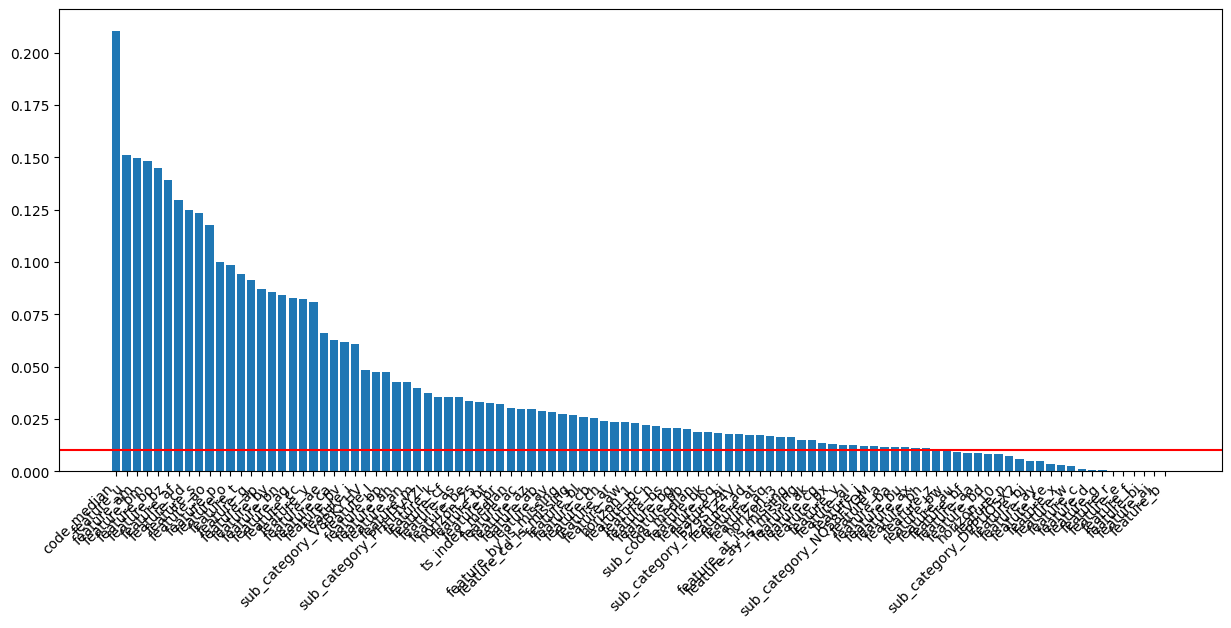

In [12]:
corr_series = pd.Series(data=target_corr, index=target_corr.index)
#corr_series = corr_series.drop(labels=['y_target'])
print(corr_series)

plt.figure(figsize=(15, 6))
plt.bar(corr_series.index, corr_series)
plt.axhline(y=0.01, color='r')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
low_corr_cols = target_corr[target_corr < 0.01].index.tolist()

print(f"{len(low_corr_cols)} columns with correlation < 0.01")

if low_corr_cols:
    traindf.drop(columns=low_corr_cols, inplace=True)
    print("Columns dropped successfully.")
else:
    print("No columns met the criteria to be dropped.")

print(f"New shape: {traindf.shape}")

21 columns with correlation < 0.01
Columns dropped successfully.
New shape: (5070542, 82)


## Drop/combine cols within clusters (ie remove redundancy)

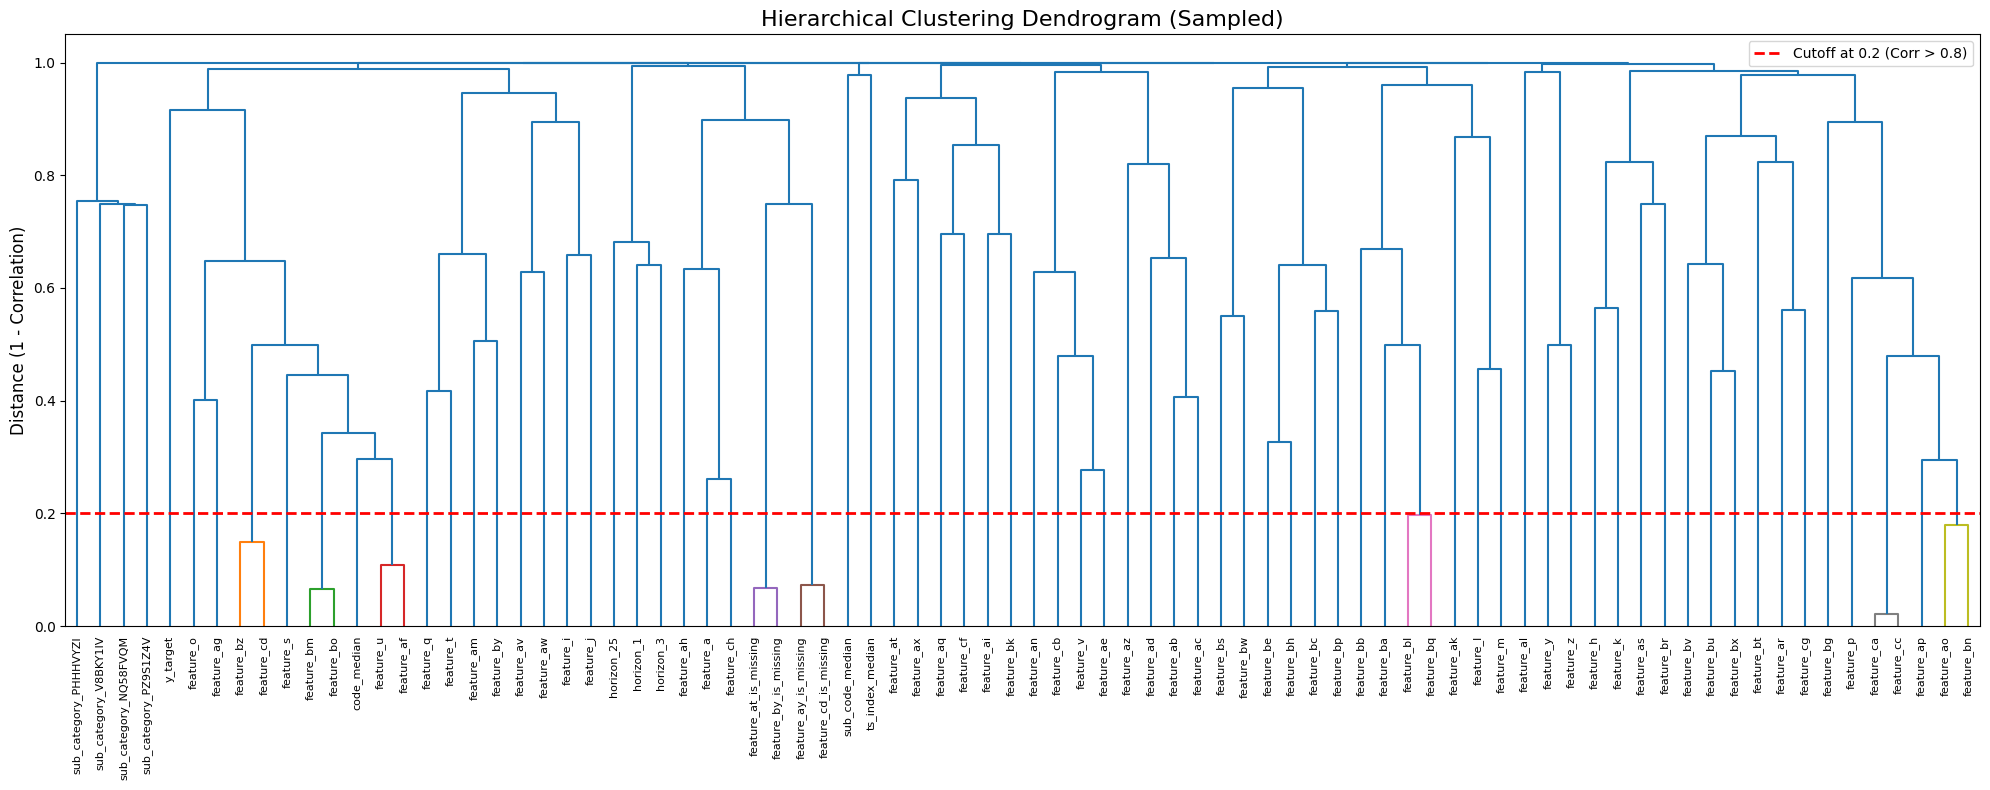

In [14]:
samples = int(len(traindf)/2)
sample_corr = traindf.sample(n=samples, random_state=42).corr().astype('float32').abs()

dissimilarity = 1 - sample_corr
distance_matrix = squareform(dissimilarity, checks=False)

Z = linkage(distance_matrix, method='complete')

plt.figure(figsize=(20, 8))
dendrogram(
    Z,
    labels=sample_corr.columns,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.2
)


cutoff = 0.2
plt.axhline(y=cutoff, color='r', linestyle='--', linewidth=2, label=f'Cutoff at {cutoff} (Corr > {1-cutoff:.1f})')

plt.title('Hierarchical Clustering Dendrogram (Sampled)', fontsize=16)
plt.ylabel('Distance (1 - Correlation)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
cluster_labels = fcluster(Z, t=cutoff, criterion='distance')

cluster_map = {}
feature_names = sample_corr.columns

for feature, cluster_id in zip(feature_names, cluster_labels):
    if cluster_id not in cluster_map:
        cluster_map[cluster_id] = []
    cluster_map[cluster_id].append(feature)

features_to_drop = []
for cluster_id, features in cluster_map.items():
    if len(features) > 1:
        corrs = {f: target_corr.get(f, 0) for f in features}

        winner = max(corrs, key=corrs.get)

        for f in features:
            if f != winner:
                features_to_drop.append(f)
                
print(f"Dropping {len(features_to_drop)} redundant features.")
traindf.drop(columns=features_to_drop, inplace=True)

print(f"Final Column Count: {traindf.shape[1]}")


Dropping 8 redundant features.
Final Column Count: 74


## Here is a cell to produce the same cleaning procedures listed until now - (aka run this before model testing below)

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import fcluster
import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb

traindf = pd.read_parquet('train.parquet', engine='pyarrow')


print('Dropping bottom and top 2.5% y_target values')
prev_len = len(traindf)
lower_bound = traindf['y_target'].quantile(0.025)
upper_bound = traindf['y_target'].quantile(0.975)
traindf = traindf[traindf['y_target'].between(lower_bound, upper_bound)]
dropped_len = len(traindf)
difference = prev_len-dropped_len

assert len(traindf) < prev_len, "No rows were filtered"
assert len(traindf) >= prev_len * 0.90, f"Too many rows dropped: {len(traindf)}/{prev_len}"

assert traindf['y_target'].min() >= lower_bound, "Values below lower bound remain"
assert traindf['y_target'].max() <= upper_bound, "Values above upper bound remain"
print(f'{difference} rows dropped')


print()


print('Filling missing values, and ohe 4 features with the most missing values')
#ohe_cols = ['feature_at', 'feature_by', 'feature_ay', 'feature_cd']
#ohe_cols = ['feature_at', 'feature_by']
ignore_cols = ['id', 'code', 'sub_code', 'sub_category', 'horizon', 'y_target', 'weight']

for col in traindf.columns:
    if col not in ignore_cols:
        #ohe cols with the most missing values (preserve potentially important data)
        """if col in ohe_cols:
            traindf[f'{col}_is_missing'] = traindf[col].isna().astype(int) """

        median_val = traindf[col].median()
        traindf[col] = traindf[col].fillna(median_val)

feature_cols = [c for c in traindf.columns if c not in ignore_cols]
assert traindf[feature_cols].isnull().sum().sum() == 0, "Missing values remain after filling"

# Assert OHE columns were created
""" for col in ohe_cols:
    assert f'{col}_is_missing' in traindf.columns, f"Missing indicator for {col} not created"
    assert traindf[f'{col}_is_missing'].isin([0, 1]).all(), f"{col}_is_missing contains invalid values" """
print('finished filling missing values')


print()


print('ohe for sub_category and horizon')
traindf = pd.get_dummies(traindf, columns=['sub_category', 'horizon'], dtype=int)
assert 'sub_category' not in traindf.columns, "sub_category column not dropped"
assert 'horizon' not in traindf.columns, "horizon column not dropped"

# Assert new columns were created
sub_cat_cols = [c for c in traindf.columns if c.startswith('sub_category_')]
horizon_cols = [c for c in traindf.columns if c.startswith('horizon_')]

assert len(sub_cat_cols) > 0, "No sub_category OHE columns created"
assert len(horizon_cols) > 0, "No horizon OHE columns created"

# Assert values are 0 or 1
for col in sub_cat_cols + horizon_cols:
    assert traindf[col].isin([0, 1]).all(), f"{col} contains non-binary values"
print('finished ohe')


print()


print('target encoding code, sub_code, and ts_index')
encode_cols = ['code', 'sub_code', 'ts_index']
for col in encode_cols:
    traindf[f'{col}_median'] = traindf.groupby(col)['y_target'].transform('median')
    traindf.drop(columns=[col], inplace=True)
for col in encode_cols:
    assert col not in traindf.columns, f"{col} not dropped after target encoding"
    assert f'{col}_median' in traindf.columns, f"{col}_median not created"

# Assert median columns have valid numeric values
for col in encode_cols:
    assert traindf[f'{col}_median'].notna().all(), f"{col}_median contains NaN values"
    assert np.isfinite(traindf[f'{col}_median']).all(), f"{col}_median contains infinite values"
print('finished target encoding')


print()


print('dropping feature with low correlation to y_target')
drop_cols = ['id']
existing_cols = [c for c in drop_cols if c in traindf.columns]
traindf.drop(columns=existing_cols, inplace=True)

corrdf = traindf.drop(columns=['y_target', 'weight'], errors='ignore')
target_corr = corrdf.corrwith(traindf['y_target']).abs()

low_corr_cols = target_corr[target_corr < 0.01].index.tolist()
if low_corr_cols:
    traindf.drop(columns=low_corr_cols, inplace=True)

    for col in low_corr_cols:
        assert col not in traindf.columns, f"Low correlation column {col} not dropped"
    
    assert 'y_target' in traindf.columns, "y_target was incorrectly dropped"
print('finished dropping low correlation features')


print()


print('dropping features with high clustering')
initial_cols_before_clustering = traindf.columns.tolist()
initial_shape = traindf.shape

cluster_df = traindf.drop(columns=['y_target', 'weight'], errors='ignore')
sample_corr = cluster_df.corr().astype('float32').abs()

assert sample_corr.shape[0] == sample_corr.shape[1], "Correlation matrix is not square"
assert sample_corr.shape[0] == sample_corr.shape[1], "Correlation matrix size doesn't match number of columns"
assert np.allclose(sample_corr, sample_corr.T), "Correlation matrix is not symmetric"

dissimilarity = 1 - sample_corr
distance_matrix = squareform(dissimilarity, checks=False)

assert distance_matrix.shape[0] == (sample_corr.shape[0] * (sample_corr.shape[0] - 1)) // 2, "Distance matrix has incorrect shape"
assert np.all(distance_matrix >= 0), "Distance matrix contains negative values"
assert np.all(distance_matrix <= 2), "Distance matrix contains values > 2 (impossible for 1-correlation)"

Z = linkage(distance_matrix, method='complete')

assert Z.shape[0] == sample_corr.shape[0] - 1, "Linkage matrix has incorrect number of rows"
assert Z.shape[1] == 4, "Linkage matrix should have 4 columns"

cutoff=0.2
cluster_labels = fcluster(Z, t=cutoff, criterion='distance')

assert len(cluster_labels) == sample_corr.shape[0], "Cluster labels length doesn't match number of features"
assert np.all(cluster_labels > 0), "Cluster labels must be positive integers"
assert cluster_labels.min() == 1, "Cluster labels should start at 1"

cluster_map = {}
feature_names = sample_corr.columns
for feature, cluster_id in zip(feature_names, cluster_labels):
    if cluster_id not in cluster_map:
        cluster_map[cluster_id] = []
    cluster_map[cluster_id].append(feature)

assert len(cluster_map) > 0, "No clusters were created"
assert sum(len(features) for features in cluster_map.values()) == len(feature_names), "Not all features assigned to clusters"


features_to_drop = []
for cluster_id, features in cluster_map.items():
    if len(features) > 1:
        corrs = {f: target_corr.get(f, 0) for f in features}

        for f in features:
            if f != 'y_target':
                assert f in target_corr.index or f == 'y_target', f"Feature {f} not found in target_corr"
        
        winner = max(corrs, key=corrs.get)

        assert winner in features, f"Winner {winner} is not in cluster {cluster_id}"
        

        for f in features:
            if f != winner:
                features_to_drop.append(f)

assert len(features_to_drop) == len(set(features_to_drop)), "features_to_drop contains duplicates"
assert 'y_target' not in features_to_drop, "y_target was marked for dropping"
assert 'weight' not in features_to_drop, "weight was marked for dropping"

num_features_to_drop = len(features_to_drop)
print(f"Dropping {num_features_to_drop} redundant features.")

traindf.drop(columns=features_to_drop, inplace=True)

for feature in features_to_drop:
    assert feature not in traindf.columns, f"Feature {feature} was not dropped"

# Assert y_target still exists
assert 'y_target' in traindf.columns, "y_target was accidentally dropped during clustering"

# Assert correct number of columns remain
expected_cols = initial_shape[1] - num_features_to_drop
assert traindf.shape[1] == expected_cols, f"Expected {expected_cols} columns, got {traindf.shape[1]}"

# Assert no rows were dropped (only columns)
assert traindf.shape[0] == initial_shape[0], f"Rows were dropped during clustering step: {initial_shape[0]} -> {traindf.shape[0]}"

# Assert at least some features remain (shouldn't drop everything)
assert traindf.shape[1] >= 2, f"Too few columns remain after clustering: {traindf.shape[1]}"

# Assert no NaN or inf values were introduced
assert not traindf.isnull().any().any(), "NaN values introduced during clustering step"
assert np.all(np.isfinite(traindf.select_dtypes(include=[np.number]))), "Infinite values introduced during clustering step"

print('finished dropping cluster cols')
print(f"Final Column Count: {traindf.shape[1]}")

Dropping bottom and top 2.5% y_target values
266872 rows dropped

Filling missing values, and ohe 4 features with the most missing values
finished filling missing values

ohe for sub_category and horizon
finished ohe

target encoding code, sub_code, and ts_index
finished target encoding

dropping feature with low correlation to y_target
finished dropping low correlation features

dropping features with high clustering
Dropping 6 redundant features.
finished dropping cluster cols
Final Column Count: 73


## Model Training

## XGB Model

In [2]:
X = traindf.drop(columns=['y_target', 'weight'])
print(X.columns)

Index(['feature_a', 'feature_h', 'feature_k', 'feature_l', 'feature_m',
       'feature_n', 'feature_o', 'feature_p', 'feature_s', 'feature_t',
       'feature_v', 'feature_ae', 'feature_af', 'feature_ag', 'feature_ah',
       'feature_ai', 'feature_am', 'feature_ao', 'feature_aq', 'feature_bg',
       'feature_bn', 'feature_bo', 'feature_bp', 'feature_bs', 'feature_bv',
       'feature_bw', 'feature_by', 'feature_bz', 'feature_cb', 'feature_cc',
       'feature_cf', 'feature_ch', 'sub_category_PHHHVYZI',
       'sub_category_V8BKY1IV', 'horizon_1', 'horizon_25', 'code_median',
       'ts_index_median'],
      dtype='object')


In [12]:
weights = traindf['weight'] if 'weight' in traindf.columns else None
X = traindf.drop(columns=['y_target', 'weight'])
y = traindf['y_target']
print(f"Training on {X.shape[0]} rows and {X.shape[1]} features.")

# 2. Split data into Training and Validation sets
# We use a validation set to stop training early if the model stops improving
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
if weights is not None:
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
        X, y, weights, test_size=0.2, random_state=42
    )
else:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    w_val = np.ones(len(y_val))


# 3. Initialize the XGBoost Model with CUDA
model = xgb.XGBRegressor(
    objective='reg:squarederror', # Standard for regression
    n_estimators=2000,            # High number, we rely on early_stopping to find the sweet spot
    learning_rate=0.05,           # Lower rate = better accuracy but slower training
    max_depth=8,                  # Depth of trees (6-10 is standard)
    
    # --- GPU SETTINGS ---
    device='cuda',                # Use NVIDIA GPU
    tree_method='hist',           # 'hist' is the fastest method for large data on GPU
    
    # Optional: Manage GPU memory chunks if you hit VRAM limits
    # max_bin=256,
    
    random_state=42,
    n_jobs=-1                     # Use all CPU cores for data loading steps
)

# 4. Train the Model
print("Starting training on GPU...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100  # Print progress every 100 trees
)

# 5. Evaluate
preds = model.predict(X_val)
rmse = mean_squared_error(y_val, preds, squared=False)
print(f"\nFinal Validation RMSE: {rmse:.5f}")
'''
def _clip01(x: float) -> float:
    return float(np.minimum(np.maximum(x, 0.0), 1.0))

def weighted_rmse_score(y_target, y_pred, w) -> float:
    denom = np.sum(w * y_target ** 2)
    ratio = np.sum(w * (y_target - y_pred) ** 2) / denom

    print(f"DEBUG: Raw Ratio = {ratio:.5f}")

    clipped = _clip01(ratio)
    val = 1.0 - clipped
    return float(np.sqrt(val))
'''
def weighted_rmse_score(y_target, y_pred, w) -> float:
    denom = np.sum(w * y_target ** 2)
    if denom == 0:
        return 0.0
    ratio = np.sum(w * (y_target - y_pred) ** 2) / denom
    return float(np.sqrt(1 - np.clip(ratio, 0.0, 1.0)))

if weights is not None:
    w_val = weights.loc[X_val.index].values
else:
    w_val = np.ones(len(y_val))

score = weighted_rmse_score(y_val.values, preds, w_val.values if hasattr(w_val, "values") else w_val)
print(f"Competition Weighted RMSE Score: {score:.5f}")

print('stats')
print("y_val stats:", y_val.min(), y_val.max(), y_val.mean(), y_val.std())
print("preds stats:", preds.min(), preds.max(), preds.mean(), preds.std())
print("weights stats:", w_val.min(), w_val.max(), w_val.mean(), np.median(w_val))
print("any NaN/inf in preds:", np.any(~np.isfinite(preds)))


Training on 5070542 rows and 71 features.
Starting training on GPU...
[0]	validation_0-rmse:3.01192	validation_1-rmse:3.01415
[100]	validation_0-rmse:2.58124	validation_1-rmse:2.61331
[200]	validation_0-rmse:2.50425	validation_1-rmse:2.56265
[300]	validation_0-rmse:2.44404	validation_1-rmse:2.52821
[400]	validation_0-rmse:2.39361	validation_1-rmse:2.50419
[500]	validation_0-rmse:2.35030	validation_1-rmse:2.48416
[600]	validation_0-rmse:2.31250	validation_1-rmse:2.46980
[700]	validation_0-rmse:2.27730	validation_1-rmse:2.45775
[800]	validation_0-rmse:2.24359	validation_1-rmse:2.44343
[900]	validation_0-rmse:2.21198	validation_1-rmse:2.43154
[1000]	validation_0-rmse:2.18038	validation_1-rmse:2.42353
[1100]	validation_0-rmse:2.15271	validation_1-rmse:2.41280
[1200]	validation_0-rmse:2.12642	validation_1-rmse:2.40319
[1300]	validation_0-rmse:2.10450	validation_1-rmse:2.39609
[1400]	validation_0-rmse:2.07987	validation_1-rmse:2.39044
[1500]	validation_0-rmse:2.05595	validation_1-rmse:2.3840

c:\Users\Kyle\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Final Validation RMSE: 2.35682
Competition Weighted RMSE Score: 0.00000
stats
y_val stats: -25.25170997855906 16.767371178084346 -0.28121525593147717 3.040872190285955
preds stats: -24.95325 15.345947 -0.27903485 1.7660786
weights stats: 0.0 22120110620.814503 14371141.114697002 2292.3294718771635
any NaN/inf in preds: False


## LGBM Model

In [12]:


# Create the dataset object (This does NOT load everything into RAM immediately in the same way)
# 'free_raw_data=False' allows you to keep the raw data if you have RAM, 
# but setting it to True (default) frees the raw arrays after constructing the histograms.

weights = traindf['weight'] if 'weight' in traindf.columns else None
X = traindf.drop(columns=['y_target'])
y = traindf['y_target']

print(f"Training on {X.shape[0]} rows and {X.shape[1]} features.")

# 2. Split data into Training and Validation sets
# We use a validation set to stop training early if the model stops improving
if weights is not None:
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
        X, y, weights, test_size=0.2, random_state=42
    )
else:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    w_train = None
    w_val = np.ones(len(y_val))

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,       # Controls complexity (31 is standard)
    'learning_rate': 0.05,
    'feature_fraction': 0.9, # Select 90% of features per tree (prevents overfitting & saves memory)
    
    # --- MEMORY OPTIMIZATIONS ---
    'device': 'gpu',         # Use GPU (make sure you installed lightgbm --gpu)
    'max_bin': 63,           # Lowering bins from 255 to 63 drastically cuts RAM with minimal accuracy loss
    'force_col_wise': True   # Forces column-wise building which is more RAM efficient for large N
}

print("Training LightGBM...")
bst = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)] # Built-in callback for early stopping
)

preds = bst.predict(X_val)
def weighted_rmse_score(y_target, y_pred, w) -> float:
    denom = np.sum(w * y_target ** 2)
    if denom == 0:
        return 0.0
    ratio = np.sum(w * (y_target - y_pred) ** 2) / denom
    return float(np.sqrt(1 - np.clip(ratio, 0.0, 1.0)))

score = weighted_rmse_score(y_val.values, preds, w_val.values if hasattr(w_val, "values") else w_val)
print(f"Competition Weighted RMSE Score: {score:.5f}")

print("stats")
print("y_val stats:", y_val.min(), y_val.max(), y_val.mean(), y_val.std())
print("preds stats:", preds.min(), preds.max(), preds.mean(), preds.std())
print("weights stats:", w_val.min(), w_val.max(), w_val.mean(), np.median(w_val))
print("any NaN/inf in preds:", np.any(~np.isfinite(preds)))

Training on 5070542 rows and 74 features.
Training LightGBM...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4021
[LightGBM] [Info] Number of data points in the train set: 4056433, number of used features: 74
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 67 dense feature groups (263.06 MB) transferred to GPU in 0.217704 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.276450
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 2.42402	valid_1's rmse: 2.51355
Competition Weighted RMSE Score: 0.00000
stats
y_val stats: -25.25170997855906 16.767371178084346 -0.28121525593147717 3.040872190285955
preds stats: -24.375791378527992 13.611377592550529

## Neural Net

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# --- Competition Score ---
def weighted_rmse_score(y_target, y_pred, w) -> float:
    denom = np.sum(w * y_target ** 2)
    if denom == 0:
        return 0.0
    ratio = np.sum(w * (y_target - y_pred) ** 2) / denom
    return float(np.sqrt(1 - np.clip(ratio, 0.0, 1.0)))

# --- Data Prep (uses cleaned traindf) ---
weights = traindf['weight'] if 'weight' in traindf.columns else None
X = traindf.drop(columns=['y_target', 'weight'], errors='ignore')
y = traindf['y_target']

# numeric only
X = X.select_dtypes(include=[np.number]).copy()

if weights is not None:
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
        X, y, weights, test_size=0.2, random_state=42
    )
else:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    w_train = np.ones(len(y_train))
    w_val = np.ones(len(y_val))

# tensors (move to GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32, device=device).unsqueeze(1)
w_train_t = torch.tensor(w_train.values if hasattr(w_train, "values") else w_train, dtype=torch.float32, device=device).unsqueeze(1)

X_val_t = torch.tensor(X_val.values, dtype=torch.float32, device=device)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32, device=device).unsqueeze(1)
w_val_t = torch.tensor(w_val.values if hasattr(w_val, "values") else w_val, dtype=torch.float32, device=device).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t, w_train_t)
val_ds = TensorDataset(X_val_t, y_val_t, w_val_t)

train_loader = DataLoader(train_ds, batch_size=16384, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16384, shuffle=False)

# --- Model ---
model = nn.Sequential(
    nn.Linear(X_train_t.shape[1], 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def weighted_mse(pred, target, weight):
    w_norm = weight / (weight.mean() + 1e-8)
    return torch.mean(w_norm * (pred - target) ** 2)

# --- Train ---
print("Starting training on GPU...")
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    for xb, yb, wb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = weighted_mse(preds, yb, wb)
        if not torch.isfinite(loss):
            raise RuntimeError("Loss is NaN/inf. Check data/weights.")
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_preds = []
        for xb, _, _ in val_loader:
            val_preds.append(model(xb).squeeze(-1).cpu().numpy())
        val_preds = np.concatenate(val_preds)

    if not np.isfinite(val_preds).all():
        raise RuntimeError("Validation predictions contain NaN/inf.")

    score = weighted_rmse_score(
        y_val_t.cpu().numpy().squeeze(),
        val_preds,
        w_val_t.cpu().numpy().squeeze()
    )

    print(
        f"Epoch {epoch}: Train Loss={train_loss/len(train_loader):.6f}, "
        f"Comp Score={score:.5f}"
    )

Using device: cuda
Starting training on GPU...
Epoch 1: Train Loss=11717467.101549, Comp Score=0.00000
Epoch 2: Train Loss=1590.396380, Comp Score=0.00000
Epoch 3: Train Loss=24.120786, Comp Score=0.00000
Epoch 4: Train Loss=11.188676, Comp Score=0.00000
Epoch 5: Train Loss=1.603614, Comp Score=0.00000
Epoch 6: Train Loss=1.054533, Comp Score=0.00000
Epoch 7: Train Loss=0.309393, Comp Score=0.00000
Epoch 8: Train Loss=1.169891, Comp Score=0.00000
Epoch 9: Train Loss=0.103913, Comp Score=0.01402
Epoch 10: Train Loss=0.377650, Comp Score=0.01224


In [6]:
traindf = pd.read_parquet('train.parquet', engine='pyarrow')
def make_submission_nn(model, train_df, test_path, feature_columns, output_path="submission.csv"):
    # Build encoders from train
    ohe_cols = ['feature_at', 'feature_by', 'feature_ay', 'feature_cd']
    ignore_cols = ['id', 'code', 'sub_code', 'sub_category', 'horizon', 'y_target', 'weight']
    encode_cols = ['code', 'sub_code', 'ts_index']

    # Load test
    testdf = pd.read_parquet(test_path, engine='pyarrow')

    # Missing indicators + median fill (from train)
    medians = train_df.drop(columns=['y_target'], errors='ignore').median(numeric_only=True)

    for col in testdf.columns:
        if col not in ignore_cols:
            if col in ohe_cols:
                testdf[f"{col}_is_missing"] = testdf[col].isna().astype(int)
            if col in medians.index:
                testdf[col] = testdf[col].fillna(medians[col])
            else:
                testdf[col] = testdf[col].fillna(0)

    # OHE for sub_category and horizon, align to train
    testdf = pd.get_dummies(testdf, columns=['sub_category', 'horizon'], dtype=int)

    # Target encoding (median from train)
    for col in encode_cols:
        if col in train_df.columns:
            # already encoded in train, so skip
            continue
        if col in testdf.columns:
            mapping = train_df.groupby(col)['y_target'].median() if col in train_df.columns else None
            if mapping is None:
                # build mapping from raw train if still available
                raise RuntimeError("Train df is already encoded; cannot build mapping for test.")
            testdf[f"{col}_median"] = testdf[col].map(mapping)
            testdf.drop(columns=[col], inplace=True)

    # If train is already encoded, use those median columns
    for col in encode_cols:
        if f"{col}_median" not in testdf.columns and f"{col}_median" in train_df.columns:
            # fallback: fill with train median of that encoded column
            testdf[f"{col}_median"] = train_df[f"{col}_median"].median()

    # Drop non-feature columns and align to training features
    X_test = testdf.drop(columns=['y_target', 'weight'], errors='ignore')
    X_test = X_test.select_dtypes(include=[np.number]).copy()

    # Align to feature_columns
    for col in feature_columns:
        if col not in X_test.columns:
            X_test[col] = 0
    X_test = X_test[feature_columns]

    # Predict
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_test.values, dtype=torch.float32, device=device)
        preds = model(X_t).squeeze(-1).cpu().numpy()

    # Save submission
    sub = pd.DataFrame({
        "id": testdf["id"].values,
        "prediction": preds
    })
    sub.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

# Usage (after training):
feature_columns = X.columns  # from your NN training cell
make_submission_nn(model, traindf, "test.parquet", feature_columns, "submission.csv")


Saved: submission.csv


# Model Performance Insights

To enhance the performance of the neural network, consider the following strategies:

1. **Data Splitting by Horizon**: Instead of using one-hot encoding, breaking the data by horizon and training separate models can be beneficial, especially if the data exhibits temporal patterns. This allows each model to specialize in a specific time frame, potentially improving predictive accuracy.

2. **Feature Engineering**: Ensure that your features are well-engineered. Consider adding features that capture temporal dynamics, such as lagged variables or rolling statistics, which can provide additional context to the model.

3. **Model Complexity**: The current model architecture is relatively simple. Depending on the complexity of your data, you might want to experiment with deeper architectures or different types of layers (e.g., convolutional layers for time series data).

4. **Regularization**: You are using dropout, which is good for preventing overfitting. However, consider experimenting with other regularization techniques, such as L2 regularization, to see if it helps improve model generalization.

5. **Hyperparameter Tuning**: The learning rate and batch size are critical hyperparameters. Consider using techniques like grid search or random search to find optimal values for these parameters.

6. **Validation Strategy**: Ensure that your validation strategy is robust. If your data is time-dependent, consider using time series cross-validation instead of a simple train-test split.

7. **Monitoring and Early Stopping**: Implement monitoring of validation loss and consider using early stopping to prevent overfitting during training.

These strategies can help improve the model's performance and generalization capabilities.